In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
%config IPCompleter.greedy=True

In [3]:
df = pd.read_csv('data/mitbih_train.csv', header=None)
df2 = pd.read_csv('data/mitbih_test.csv', header=None)
df = pd.concat([df, df2], axis=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [4]:
M = df.values
X = M[:,:-1]
y = M[:,-1]
print(X.shape)
print(y.shape)

(109446, 187)
(109446,)


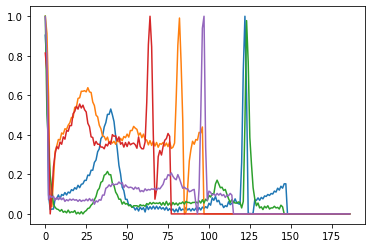

In [5]:
plt.plot(X[np.random.randint(0,100,5)].transpose())

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Model

The model is based on this article : https://arxiv.org/abs/1805.00794

In [7]:
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Activation, Add, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [25]:
input_shape = (187, 1)

I = Input(input_shape)
C = Conv1D(filters=32, kernel_size=5)(I)

C11 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(C)
C12 = Conv1D(filters=32, kernel_size=5, padding='same')(C11)
A11 = Add()([C, C12])
R11 = Activation(activation='relu')(A11)
M11 = MaxPool1D(pool_size=5, strides=2)(R11)

C21 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M11)
C22 = Conv1D(filters=32, kernel_size=5, padding='same')(C21)
A21 = Add()([M11, C22])
R21 = Activation(activation='relu')(A21)
M21 = MaxPool1D(pool_size=5, strides=2)(R21)

C31 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M21)
C32 = Conv1D(filters=32, kernel_size=5, padding='same')(C31)
A31 = Add()([M21, C32])
R31 = Activation(activation='relu')(A31)
M31 = MaxPool1D(pool_size=5, strides=2)(R31)

C41 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M31)
C42 = Conv1D(filters=32, kernel_size=5, padding='same')(C41)
A41 = Add()([M31, C42])
R41 = Activation(activation='relu')(A41)
M41 = MaxPool1D(pool_size=5, strides=2)(R41)

C51 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M41)
C52 = Conv1D(filters=32, kernel_size=5, padding='same')(C51)
A51 = Add()([M41, C52])
R51 = Activation(activation='relu')(A51)
M51 = MaxPool1D(pool_size=5, strides=2)(R51)

F1 = Flatten()(M51)
D1 = Dense(32)(F1)
R1 = Activation(activation='relu')(D1)
D2 = Dense(32)(R1)
D3 = Dense(5)(D2)

O = Activation(activation='softmax')(D3)

model = Model(inputs=I, outputs=O)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 183, 32)      192         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 183, 32)      5152        conv1d_33[0][0]                  
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 183, 32)      5152        conv1d_34[0][0]                  
____________________________________________________________________________________________

"For training the networks, we used Adam optimization method with the learning rate, beta-1, and beta-2 of 0.001, 0.9, and 0.999, respectively. Learning rate is decayed exponentially with the decay factor of 0.75 every 10000 iterations."

In [26]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=10000, decay_rate=0.75)
adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [27]:
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
mc = tf.keras.callbacks.ModelCheckpoint('weights/weights{epoch:08d}.h5', save_weights_only=True, period=4)
history = model.fit(np.expand_dims(X_train, axis=2), 
                    y_train, 
                    validation_split=0.15,
                    epochs=20,
                    batch_size=256,
                    callbacks=[mc])

Train on 79074 samples, validate on 13955 samples
Epoch 1/20
79074/79074 [==============================] - 20s 257us/sample - loss: 0.3334 - accuracy: 0.9011 - val_loss: 0.1517 - val_accuracy: 0.9609
Epoch 2/20
79074/79074 [==============================] - 19s 245us/sample - loss: 0.1172 - accuracy: 0.9681 - val_loss: 0.0923 - val_accuracy: 0.9753
Epoch 3/20
79074/79074 [==============================] - 19s 243us/sample - loss: 0.0917 - accuracy: 0.9746 - val_loss: 0.0763 - val_accuracy: 0.9801
Epoch 4/20
79074/79074 [==============================] - 20s 253us/sample - loss: 0.0776 - accuracy: 0.9780 - val_loss: 0.0707 - val_accuracy: 0.9796
Epoch 5/20
79074/79074 [==============================] - 20s 247us/sample - loss: 0.0662 - accuracy: 0.9810 - val_loss: 0.0646 - val_accuracy: 0.9828
Epoch 6/20
79074/79074 [==============================] - 19s 246us/sample - loss: 0.0624 - accuracy: 0.9820 - val_loss: 0.0636 - val_accuracy: 0.9814
Epoch 7/20
79074/79074 [====================

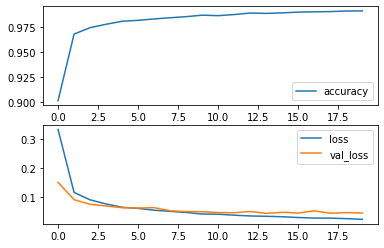

In [29]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.legend(["accuracy"])
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend(["loss", "val_loss"])
plt.show()

The loss converges at around 10 epochs.

In [96]:
results = model.evaluate(np.expand_dims(X_test, axis=2), y_test, batch_size=128)

16417/16417 [==============================] - 7s 453us/sample - loss: 0.0535 - acc: 0.9857


In [118]:
labels = ["N", "S", "V", "F", "Q"]
raw_predictions = model.predict(np.expand_dims(X_test, axis=2), batch_size=128)
#predictions = [p['class_ids'][0] for p in raw_predictions]
#confusion_matrix = tf.confusion_matrix(labels, predictions)